# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

url = "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv"
peng = pd.read_csv(url)

cols = ["species","island","bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g","sex","year"]
peng = peng[cols].dropna().reset_index(drop=True)

y = peng["species"]
X = peng.drop(columns=["species"])

num_sel = make_column_selector(dtype_include=np.number)
cat_sel = make_column_selector(dtype_include=object)

num_cols = num_sel(X)
cat_cols = cat_sel(X)

prep_knn = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("scaler", StandardScaler(), num_cols),
    ],
    remainder="drop"
)

prep_tree = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("passthrough", "passthrough", num_cols),
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

models = {
    "knn_k5": Pipeline([("prep", prep_knn), ("clf", KNeighborsClassifier(n_neighbors=5))]),
    "knn_k15": Pipeline([("prep", prep_knn), ("clf", KNeighborsClassifier(n_neighbors=15))]),
    "tree_depth3": Pipeline([("prep", prep_tree), ("clf", DecisionTreeClassifier(max_depth=3, random_state=42))]),
    "tree_ccp001": Pipeline([("prep", prep_tree), ("clf", DecisionTreeClassifier(ccp_alpha=0.01, random_state=42))]),
}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)

print("Fitted models:", list(models.keys()))

Fitted models: ['knn_k5', 'knn_k15', 'tree_depth3', 'tree_ccp001']


Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.


=== knn_k5 ===
Confusion Matrix (rows=actual, cols=predicted, label order: ['Adelie', 'Chinstrap', 'Gentoo'] )
[[36  1  0]
 [ 1 16  0]
 [ 0  0 30]]
Accuracy: 0.976

Per-class metrics:
  Adelie     Precision=0.973  Recall=0.973  F1=0.973  AUC=0.999
  Chinstrap  Precision=0.941  Recall=0.941  F1=0.941  AUC=0.999
  Gentoo     Precision=1.000  Recall=1.000  F1=1.000  AUC=1.000

=== knn_k15 ===
Confusion Matrix (rows=actual, cols=predicted, label order: ['Adelie', 'Chinstrap', 'Gentoo'] )
[[36  1  0]
 [ 0 17  0]
 [ 0  0 30]]
Accuracy: 0.988

Per-class metrics:
  Adelie     Precision=1.000  Recall=0.973  F1=0.986  AUC=1.000
  Chinstrap  Precision=0.944  Recall=1.000  F1=0.971  AUC=1.000
  Gentoo     Precision=1.000  Recall=1.000  F1=1.000  AUC=1.000

=== tree_depth3 ===
Confusion Matrix (rows=actual, cols=predicted, label order: ['Adelie', 'Chinstrap', 'Gentoo'] )
[[37  0  0]
 [ 1 16  0]
 [ 2  0 28]]
Accuracy: 0.964

Per-class metrics:
  Adelie     Precision=0.925  Recall=1.000  F1=0.961  A

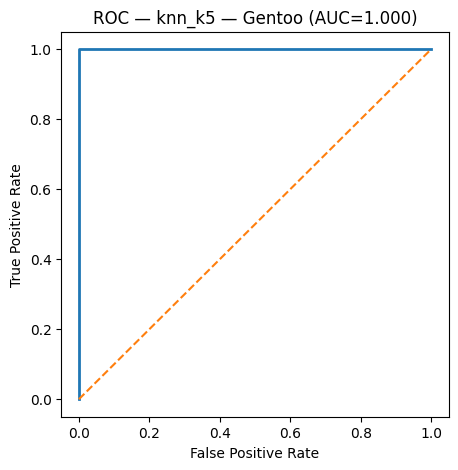

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_recall_fscore_support,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize

labels = sorted(y.unique())

def evaluate_model(name, pipe, X_test, y_test, labels):
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    prec, rec, f1, support = precision_recall_fscore_support(
        y_test, y_pred, labels=labels, zero_division=0
    )

    if hasattr(pipe.named_steps[list(pipe.named_steps.keys())[-1]], "predict_proba"):
        proba = pipe.predict_proba(X_test)
        y_test_bin = label_binarize(y_test, classes=labels)
        if proba.shape[1] == 1:
            proba = np.hstack([1 - proba, proba])
        auc_per_class = roc_auc_score(y_test_bin, proba, average=None, multi_class="ovr")
    else:
        proba, auc_per_class = None, [np.nan]*len(labels)

    print(f"\n=== {name} ===")
    print("Confusion Matrix (rows=actual, cols=predicted, label order:", labels, ")")
    print(cm)
    print(f"Accuracy: {acc:.3f}")
    print("\nPer-class metrics:")
    for i, lab in enumerate(labels):
        print(f"  {lab:9s}  Precision={prec[i]:.3f}  Recall={rec[i]:.3f}  F1={f1[i]:.3f}  AUC={auc_per_class[i]:.3f}")

    return {"name": name, "acc": acc, "cm": cm, "prec": prec, "rec": rec, "f1": f1, "auc": auc_per_class, "proba": proba}

results = []
for name, pipe in models.items():
    results.append(evaluate_model(name, pipe, X_test, y_test, labels))

model_key_for_roc = "knn_k5"
species_to_plot = "Gentoo"

pipe = models[model_key_for_roc]
proba = pipe.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=labels)

cls_idx = labels.index(species_to_plot)

fpr, tpr, thr = roc_curve(y_test_bin[:, cls_idx], proba[:, cls_idx])
auc_val = roc_auc_score(y_test_bin[:, cls_idx], proba[:, cls_idx])

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC — {model_key_for_roc} — {species_to_plot} (AUC={auc_val:.3f})")
plt.show()

Best overall: kNN (K=15) with accuracy = 0.988 and near-perfect F1s (Adelie 0.986, Chinstrap 0.971, Gentoo 1.000)

Runners-up: kNN (K=5) and Tree (ccp_alpha=0.001) at 0.976. Tree (max_depth=3) at 0.964

AUCs: kNN = 1.00 for all classes. Trees slightly lower (0.96-0.97 for Adelie/Gentoo), matching their few errors

Takeaway: Use kNN (K=15) with best accuracy and class wise metrics with stable generalization

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!wget -q https://quarto.org/download/latest/quarto-linux-amd64.deb
!sudo dpkg -i quarto-linux-amd64.deb || true
!sudo apt-get -y -f install
!sudo dpkg -i quarto-linux-amd64.deb
!quarto check

Selecting previously unselected package quarto.
(Reading database ... 121703 files and directories currently installed.)
Preparing to unpack quarto-linux-amd64.deb ...
Unpacking quarto (1.8.26) ...
Setting up quarto (1.8.26) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
(Reading database ... 124554 files and directories currently installed.)
Preparing to unpack quarto-linux-amd64.deb ...
Unpacking quarto (1.8.26) over (1.8.26) ...
Setting up quarto (1.8.26) ...
Quarto 1.8.26
[✓] Checking environment information...
      Quarto cache location: /root/.cache/quarto
[✓] Checking versions of quarto binary dependencies...
      Pandoc version 3.6.3: OK
      Dart Sass version 1.87.0: OK
      Deno version 2.3.1: OK
      Typst version 0.13.0: OK
[✓] Checking versions of quarto dependencies......OK
[✓] Checking Quarto installation......OK
      Version: 1.8.26
      Path: /op

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Example: adjust the path to where your file actually is
%cd "/content/drive/My Drive/Colab Notebooks"
!quarto render PA8.2.ipynb --to html

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks
pandoc 
  to: html
  output-file: PA8.2.html
  standalone: true
  section-divs: true
  html-math-method: mathjax
  wrap: none
  default-image-extension: png
  variables: {}
  
metadata
  document-css: false
  link-citations: true
  date-format: long
  lang: en
  title: Palmer Penguins Modeling
  
